In [2]:
pip install pandas_datareader

  Using cached pandas_datareader-0.8.1-py2.py3-none-any.whl (107 kB)
  Using cached lxml-4.5.0-cp38-cp38-win_amd64.whl (3.7 MB)
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in c:\users\gowri\anaconda3\envs\geo_env\lib\site-packages (from requests>=2.3.0->pandas_datareader) (1.25.9)



In [3]:
import pandas_datareader as web

C:\Users\Gowri\Anaconda3\envs\geo_env\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [17]:

stocks = []
f = open("symbols.txt","r")
#All symbols are stored in a file called symbols.txt
for line in f:
    stocks.append(line.strip())

f.close()

In [6]:
web.DataReader(stocks,"yahoo", start ="2000-1-1", end="2019-12-31")["Adj Close"].to_csv("prices.csv")
web.DataReader(stocks,"yahoo", start ="2000-1-1", end="2019-12-31")["Volume"].to_csv("volume.csv")

C:\Users\Gowri\Anaconda3\envs\geo_env\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'WCG', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\Gowri\Anaconda3\envs\geo_env\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'ARNC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import warnings
warnings.filterwarnings("ignore")

In [19]:
prices = pd.read_csv("prices.csv", index_col ="Date", parse_dates=True)
volumechanges = pd.read_csv("volume.csv", index_col ="Date", parse_dates =True).pct_change()*100

today = dt.date(2000, 1, 15)
simend = dt.date(2019, 12, 31)
tickers = []
transactionid =0
money = 1000000
portfolio ={}
activelog = []
transactionlog =[]
#activelog stores open positions and transaction log stores every transaction for 20 yrs


In [20]:
def getprice(date,ticker):
    global prices
    return prices.loc[date][ticker]

#Transaction function
#Unique id for each transaction; ticker- stock symbol; amount- the amount that was bought/sold;
#price: the price at which stocks were bought/sold; type: this can either be “buy” or “sell”; 
def transaction(id, ticker, amount, price, type, info):
    global transactionid
    if type == "buy":
        exp_date = today + dt.timedelta(days=14)
        transactionid+=1
    else:
        exp_date = today
    if type == "sell":
        data = {"id": id, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "info": info}
    elif type == "buy":
        data = {"id": transactionid, "ticker": ticker, "amount": amount, "price": price, "date": today, "type": type,
                "exp_date": exp_date, "info": info}
        activelog.append(data)
    transactionlog.append(data)
    
def buy(interestlst, allocated_money):
    global money, portfolio
    for item in interestlst:
        price = getprice(today, item)
        if not np.isnan(price):
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            portfolio[item] += quantity
            transaction(0, item, quantity, price, "buy", "")


def sell():
    global money, portfolio, prices, today
    itemstoremove = []
    for i in range(len(activelog)):
        log = activelog[i]
        if log["exp_date"] <= today and log["type"] == "buy":
            tickprice = getprice(today, log["ticker"])
            if not np.isnan(tickprice):
                money += log["amount"]*tickprice
                portfolio[log["ticker"]] -= log["amount"]
                transaction(log["id"], log["ticker"], log["amount"], tickprice, "sell", log["info"])
                itemstoremove.append(i)
            else:
                log["exp_date"] += dt.timedelta(days=1)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


def simulation():
    global today, volumechanges, money
    start_date = today - dt.timedelta(days=14)
    series = volumechanges.loc[start_date:today].mean()
    interestlst = series[series > 100].index.tolist()
    sell()
    if len(interestlst) > 0:
        #moneyToAllocate = 500000/len(interestlst)
        moneyToAllocate = currentvalue()/(2*len(interestlst))
        buy(interestlst, moneyToAllocate)


def getindices():
    global tickers
    f = open("symbols.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()


def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)


def currentvalue():
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not np.isnan(tickprice):
            value += portfolio[ticker]*tickprice
    return int(value*100)/100

plot_value = []
plot_date = [] 

def main():
    global today
    getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        currentpvalue = currentvalue()
        print(currentpvalue, today)
        plot_value.append(currentpvalue)
        plot_date.append(today)
        today += dt.timedelta(days=7)

main()
 


1000000.0 2000-01-18
1001697.18 2000-01-25
1002449.56 2000-02-01
1040707.54 2000-02-08
1020590.81 2000-02-15
1011213.08 2000-02-22
1034835.28 2000-02-29
973656.51 2000-03-07
944814.15 2000-03-14
1005766.14 2000-03-21
984543.51 2000-03-28
1012937.37 2000-04-04
1053317.39 2000-04-11
998648.83 2000-04-18
1034526.46 2000-04-25
1049007.38 2000-05-02
1070859.76 2000-05-09
1100809.53 2000-05-16
1080108.1 2000-05-23
1114314.31 2000-05-30
1134275.45 2000-06-06
1150732.12 2000-06-13
1210740.05 2000-06-20
1231382.74 2000-06-27
1220032.24 2000-07-05
1271886.09 2000-07-12
1253993.79 2000-07-19
1284195.01 2000-07-26
1326845.95 2000-08-02
1336102.54 2000-08-09
1364135.11 2000-08-16
1355496.41 2000-08-23
1368657.71 2000-08-30
1364947.61 2000-09-06
1408012.0 2000-09-13
1394370.29 2000-09-20
1433064.4 2000-09-27
1432398.32 2000-10-04
1341374.58 2000-10-11
1311614.01 2000-10-18
1311515.93 2000-10-25
1369405.42 2000-11-01
1382340.69 2000-11-08
1381859.52 2000-11-15
1374064.16 2000-11-22
1390354.82 2000-11

10506470.78 2007-03-28
10721360.5 2007-04-04
10808389.51 2007-04-11
11382630.92 2007-04-18
11395654.27 2007-04-25
10864078.92 2007-05-02
10974185.5 2007-05-09
10681284.83 2007-05-16
10805948.03 2007-05-23
10861487.41 2007-05-30
11289704.25 2007-06-06
11194502.13 2007-06-13
11194502.13 2007-06-20
11383944.39 2007-06-27
11778030.34 2007-07-05
11686678.97 2007-07-12
11628808.58 2007-07-19
11139071.31 2007-07-26
11045906.75 2007-08-02
11330423.64 2007-08-09
11330423.64 2007-08-16
11330423.64 2007-08-23
11330423.64 2007-08-30
11330423.64 2007-09-06
10994391.14 2007-09-13
11445061.18 2007-09-20
11493635.56 2007-09-27
12063843.18 2007-10-04
12888446.17 2007-10-11
13230510.96 2007-10-18
12910752.82 2007-10-25
12789597.34 2007-11-01
11789504.85 2007-11-08
11914633.06 2007-11-15
11736638.72 2007-11-23
12004470.82 2007-11-30
12247011.15 2007-12-07
12032551.87 2007-12-14
12231048.46 2007-12-21
12402065.58 2007-12-28
11996493.98 2008-01-04
11996493.98 2008-01-11
11996493.98 2008-01-18
11996493.98 2

26416128.93 2014-02-27
25186258.48 2014-03-06
24872240.28 2014-03-13
25007358.71 2014-03-20
25488924.76 2014-03-27
25907519.59 2014-04-03
25515796.33 2014-04-10
25469111.38 2014-04-17
25414200.07 2014-04-24
25487715.47 2014-05-01
25370705.02 2014-05-08
25765488.99 2014-05-15
25319894.38 2014-05-22
25547331.96 2014-05-29
25929608.96 2014-06-05
26138176.32 2014-06-12
26765227.62 2014-06-19
26783829.74 2014-06-26
27078045.57 2014-07-03
26675537.08 2014-07-10
26060497.16 2014-07-17
26216220.3 2014-07-24
25032788.27 2014-07-31
24680319.65 2014-08-07
25084740.1 2014-08-14
25394136.23 2014-08-21
24473123.14 2014-08-28
24251503.58 2014-09-04
24463732.97 2014-09-11
24931463.63 2014-09-18
24667700.34 2014-09-25
24433815.66 2014-10-02
23514605.89 2014-10-09
23024438.46 2014-10-16
23218339.36 2014-10-23
23218339.36 2014-10-30
23808237.66 2014-11-06
23931349.72 2014-11-13
24326159.72 2014-11-20
25071800.71 2014-11-28
25071800.71 2014-12-05
25060853.45 2014-12-12
25356851.16 2014-12-19
25497490.8 20

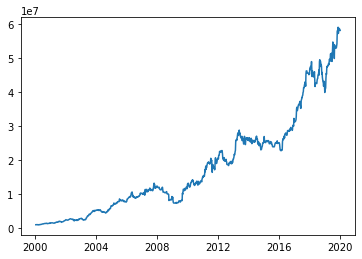

In [21]:
import matplotlib.pyplot as plt
plt.plot(plot_date, plot_value)